In [92]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

f = open("transaction-data-adhoc-analysis.json", "r")
data = json.load(f)
    
""" 
headers: 'address', 'birthdate', 'mail', 'name', 
    'sex', 'username', 'transaction_items', 'transaction_value', 
    'transaction_date'
"""
df_data = pd.DataFrame(data)

In [93]:
def order_count(orders, column):
    order = [x.split(",") for x in orders.split(";")]
    order = [item for sublist in order for item in sublist]
    order_number = order[order.index(column) + 1]
    order_number = int(order_number[2:len(order_number)-1])
    return order_number

# creating an order tally
order_list = []
for orders in df_data['transaction_items']:
    for order in orders.split(";"):
        category, order_name, order_number = order.split(",")
        if order_name not in order_list:
            order_list.append(order_name)
    
for orders in order_list:
    df_data[orders] = df_data['transaction_items'].apply(lambda row: order_count(row, orders) if orders in row else 0)

df_data.loc[:,['username', 'transaction_items', 'Beef Chicharon', 'Nutrional Milk', 'Orange Beans', 'Gummy Vitamins',
       'Yummy Vegetables', 'Gummy Worms', 'Kimchi and Seaweed']].head(5)

,username,transaction_items,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
0,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",4,0,0,0,0,0,0
1,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",3,4,1,0,0,0,0
2,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",0,0,0,3,2,0,0
3,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",0,0,0,0,1,0,0
4,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",0,0,3,1,0,4,0


In [95]:
# getting the month from transaction_date
def find_month(date):
    months = ["", "January", "February", "March", 
              "April", "May", "June", "July", "August",
             "September", "October", "November", "December"]
    
    return months[int(date[5:7])]

df_data['month'] = df_data['transaction_date'].apply(find_month)
df_data.loc[:,['username', 'transaction_date', 'month']].head(5)

,username,transaction_date,month
0,veronicawells,2022/01/12,January
1,cgilbert,2022/01/12,January
2,cgilbert,2022/01/08,January
3,cgilbert,2022/01/10,January
4,qhernandez,2022/01/24,January


In [96]:
# pivot table with months and order count
df_pivotcount_unarranged = pd.pivot_table(data = df_data, index = 'month', values = order_list, aggfunc = 'sum')
df_pivotcount = df_pivotcount_unarranged.reindex(['January', 'February', 'March', 'April', 'May', 'June'])

df_pivotcount

,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables
month,,,,,,,
January,9665,9681,9559,9676,9727,9774,9959
February,10001,9980,9996,9949,9691,10037,10256
March,9816,10145,9986,9967,9876,9611,9896
April,9890,9842,10043,9921,9786,9914,9861
May,10028,9948,9801,9773,9881,9964,9735
June,9902,9980,9934,10104,9767,10106,9722


In [147]:
# pivot table with months and sale value
def convert_string(N):
    return "".join([str(i) for i in list(N)])


df_datavalue = df_data[["username", "month", "transaction_items", "transaction_value"] + order_list].copy()
for order in order_list:
    df_datavalue[order] = df_datavalue[order].apply(lambda x: 0 if x == 0 else 1)

    
price_list = dict()
for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    df_datavalue['transposition'] = df_datavalue[df_datavalue['month'] == 'January'].loc[:,'Beef Chicharon':
        'Kimchi and Seaweed'].apply(convert_string, axis=1)

df_datavalue['transposition'].value_counts().head(10)

1000000    686
0001000    679
0000100    676
0000001    669
0010000    661
0000010    660
0100000    657
0010100    242
0001100    236
0001010    234
Name: transposition, dtype: int64

<AxesSubplot:xlabel='month'>

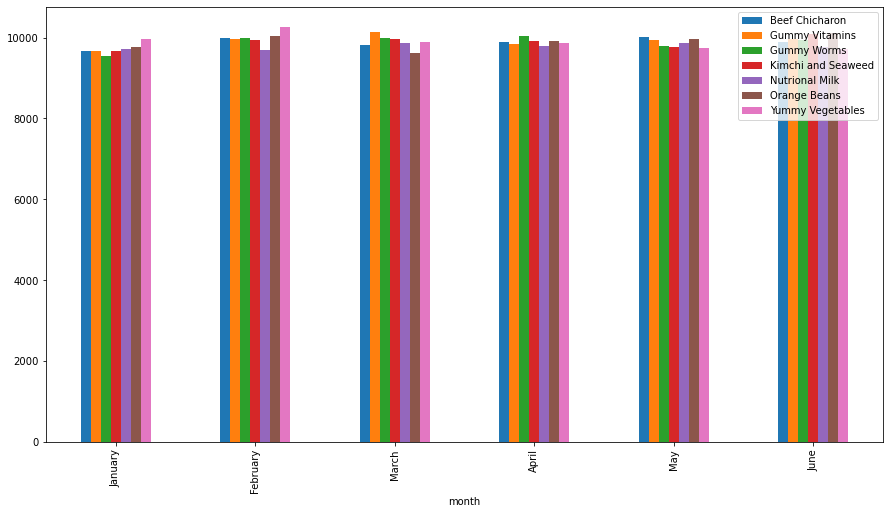

In [126]:
df_pivotcount.plot(kind="bar",figsize=(15, 8))

In [124]:
f.close()

In [ ]:
monthly_sales = []
for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    temp = []
    for order in order_list:
        temp.append(df_pivotcount.loc[month, order])
    monthly_sales.append(temp)

transaction_values = []
for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    transaction_values.append(np.sum(df_data[df_data['month'] == month].loc[:, 'transaction_value']))

monthly_sales = np.array(monthly_sales)
transaction_values = np.array(transaction_values)

item_cost = np.linalg.solve(monthly_sales, transaction_values)
